In [112]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import linregress
%matplotlib widget

# Calibrating Frequency / Voltage

maxV: 4.02381, minV: 1.34803


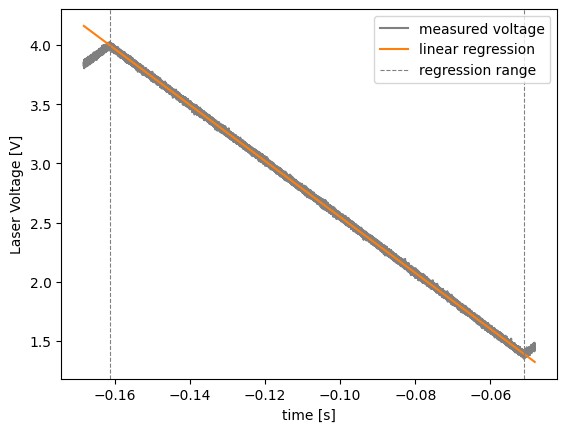

In [23]:
dataframe = read_csv("4_4_1-V2.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
t, c1, c2 = data[:, 0], data[:, 1], data[:, 2]

# linear regression for voltage curve
voltage_sweep_bounds = (np.argmax(c1), np.argmin(c1))
print(f"maxV: {max(c1)}, minV: {min(c1)}")
m, c, _, _, _ = linregress(t[voltage_sweep_bounds[0]:voltage_sweep_bounds[1]], c1[voltage_sweep_bounds[0]:voltage_sweep_bounds[1]])
c1_linearised = m * t + c

plt.plot(t, c1, color='gray', label='measured voltage')
plt.plot(t, c1_linearised, color='C1', label='linear regression')

plt.xlabel("time [s]")
plt.ylabel("Laser Voltage [V]")

plt.axvline(t[voltage_sweep_bounds[0]], linestyle='--', c='gray', linewidth=0.8, label='regression range')
plt.axvline(t[voltage_sweep_bounds[1]], linestyle='--', c='gray', linewidth=0.8)

plt.legend(loc="upper right")
plt.savefig("plots/voltageLinearise_FS.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

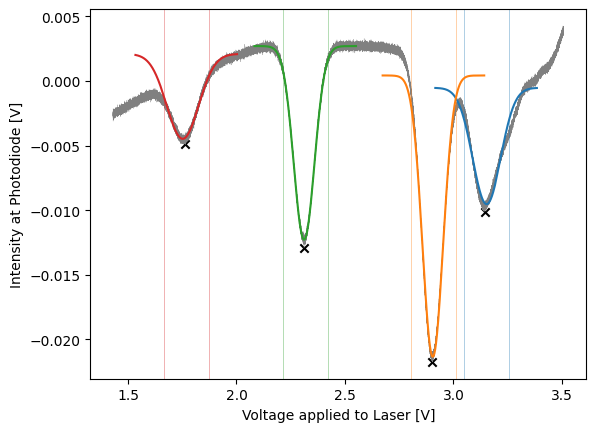

In [29]:
# Find peaks (without gaussians)
peaks = find_peaks(-c2, height=0.004, distance=10000)[0]
xpeaks = np.array([c1_linearised[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

# voltage at peaks (not good cause of voltage jitter, should fit a straight line first)
peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak
peak_width = 5000 # given in number of neighbouring datapoints
peak_skew_factor = 1.8 # > 1 shifts boundaries further right
gaussian_fit_boundaries = [(int(i - peak_width), int(i + peak_skew_factor * peak_width / 2)) for i in peaks]

# fit function
def gaussian(vL, A, v0, vD, DC_offset):
	return - A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2)) + DC_offset

# fitting and plotting
peak_info = []
for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.003, xpeaks[i], 0.01 / 2, 0.1
    (A, v0, vD, DC_offset), _ = curve_fit(gaussian, c1_linearised[LB:UB], c2[LB:UB], initialguess)

    plot_boundary_extension = 6000
    x_gaussian_fit = np.linspace(c1_linearised[LB-plot_boundary_extension], c1_linearised[UB+plot_boundary_extension], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD, DC_offset)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '-', c='C'+str(i), zorder=100)

    # add peak frequency and FWHM to peak_info list
    peak_info.append((v0, vD))

#plot original signal
trim_right = 30000
trim_left = 5000

plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(c1_linearised[trim_right:-trim_left:1], c2[trim_right:-trim_left:1], linewidth=0.2, c='gray')
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Voltage applied to Laser [V]")

# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=c1_linearised[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)

plt.savefig("plots/intesityVoltage_FS.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

-4.89364e+09


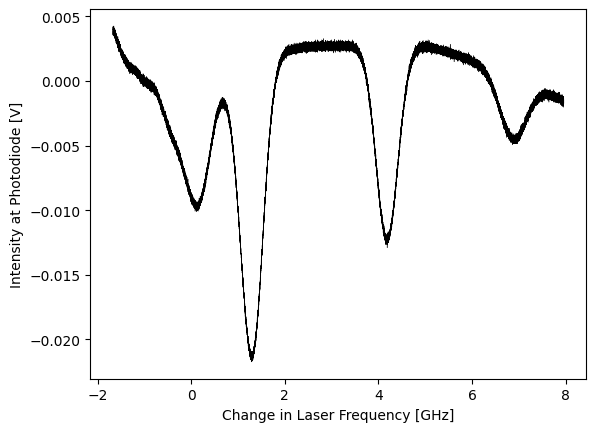

In [4]:
f0 = 384.2304844685e12
f1 = f0 + 1.296117462789e9
f2 = f1 + 3.035732439e9 
f3 = f2 + 2.500832709015e9
peakFrequencies = np.array([f0,f1,f2,f3])
peakVoltages = [v for (v, _) in peak_info] 
df_dv, intercept, _, _, _ = linregress(peakVoltages, peakFrequencies)

freq = c1_linearised * df_dv + intercept
start_trim = 30000
end_trim = 10000

freq = (freq - f0) / 1e9
# change xaxis units to shift in GHz
plt.plot(freq[start_trim:-end_trim:1], c2[start_trim:-end_trim:1], linewidth=0.3, c='black')

plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Change in Laser Frequency [GHz]")

plt.savefig("plots/intensityFrequency.png", dpi=300, bbox_inches='tight', pad_inches=0.05)
print(f"{df_dv:.5e}")



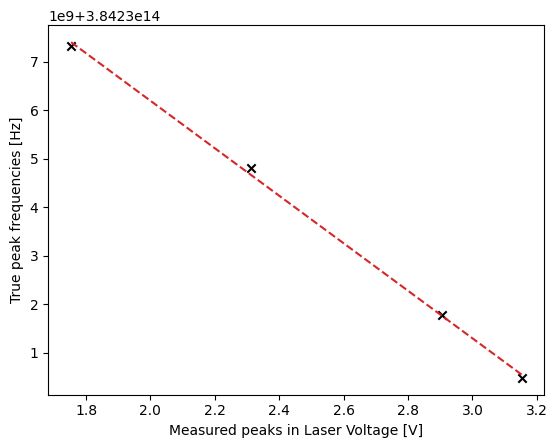

In [5]:
plt.scatter(peakVoltages, peakFrequencies, marker='x', c='black')
plt.plot(peakVoltages, df_dv * np.array(peakVoltages) + intercept, linestyle='--', c='C3')
plt.xlabel("Measured peaks in Laser Voltage [V]")
plt.ylabel("True peak frequencies [Hz]")

plt.savefig("plots/truepeaks.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

### FWHM of peaks

In [39]:
for (v, vD) in peak_info:
    print(f"Voltage: {v:.2f}\tFWHM: {-vD * df_dv:5e}")

Voltage: 3.15	FWHM: 7.418454e+08
Voltage: 2.90	FWHM: 5.457200e+08
Voltage: 2.31	FWHM: 5.505107e+08
Voltage: 1.75	FWHM: 8.475940e+08


### Fitting the triple gaussians (RB85_ Fg=2)

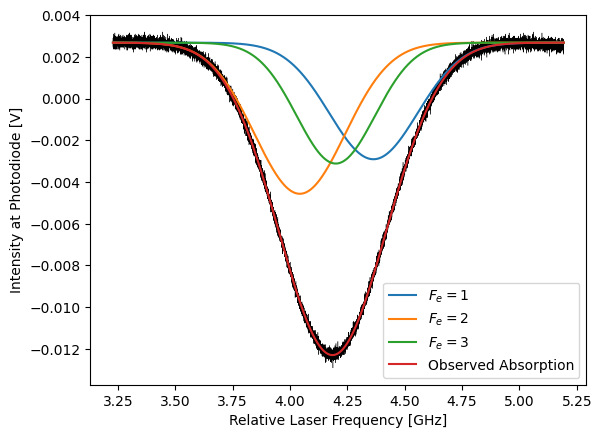

In [111]:
start_trim = 76000
end_trim = 36000

xdata = freq[start_trim:-end_trim] 
ydata = c2[start_trim:-end_trim]

# Find peak
peakIndex = np.where(ydata == min(ydata))[0][0]
xPeak = xdata[peakIndex]

# define fitting function
A_ratios = [27,35,28]
A_sum = np.sum(A_ratios)
def tripleGaussian(x, A, f00, f01, f02, fD0, fD1, fD2, offset):
    sum = - A * A_ratios[0]/A_sum  * np.exp(-4 * np.log(2) * pow((x - f00) / fD0, 2))
    sum += - A * A_ratios[1]/A_sum * np.exp(-4 * np.log(2) * pow((x - f01) / fD1, 2))
    sum += - A * A_ratios[2]/A_sum * np.exp(-4 * np.log(2) * pow((x - f02) / fD2, 2))
	
    return sum + offset

initialguess = 0.013/3, xPeak, xPeak, xPeak, 0.6, 0.6, 0.6, 0.003
(A, f00, f01, f02, fD0, fD1, fD2, offset), _ = curve_fit(tripleGaussian, xdata, ydata, initialguess)
yGaussian0 = gaussian(xdata, A * A_ratios[0]/A_sum, f00, fD0, offset)
yGaussian1 = gaussian(xdata, A * A_ratios[1]/A_sum, f01, fD1, offset)
yGaussian2 = gaussian(xdata, A * A_ratios[2]/A_sum, f02, fD2, offset)
plt.plot(xdata, yGaussian0, zorder=100, label=r"$F_e = 1$")
plt.plot(xdata, yGaussian1, zorder=100, label=r"$F_e = 2$")
plt.plot(xdata, yGaussian2, zorder=100, label=r"$F_e = 3$")
plt.plot(xdata, tripleGaussian(xdata, A, f00, f01, f02, fD0, fD1, fD2, offset), zorder=100, label="Observed Absorption")

# fitting and plotting

#def gaussian(vL, A, v0, vD, DC_offset):
plt.legend()
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Relative Laser Frequency [GHz]")
plt.plot(xdata, ydata, linewidth=0.3, c='black')

### Fitting the triple gaussians (RB87_ Fg=2)

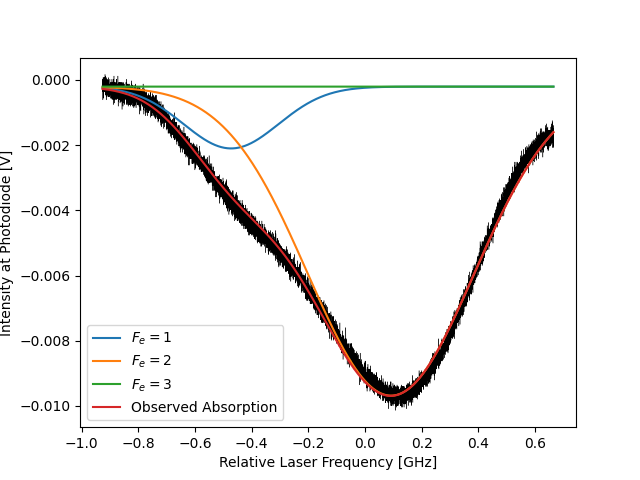

In [138]:
plt.close()
start_trim = 37000
end_trim = 78500

#def line(x, m, c):
#    return m*x + c
#ySkewLine = line(xdata, -0.000, -0.001)

xdata = freq[start_trim:-end_trim] 
ydata = c2[start_trim:-end_trim]

# Find peak
peakIndex = np.where(ydata == min(ydata))[0][0]
xPeak = xdata[peakIndex]

# define fitting function
A_ratios = [1, 5, 14]
A_sum = np.sum(A_ratios)
def tripleGaussian(x, A, f00, f01, f02, fD0, fD1, fD2, offset):
    sum = - A * A_ratios[0]/A_sum  * np.exp(-4 * np.log(2) * pow((x - f00) / fD0, 2))
    sum += - A * A_ratios[1]/A_sum * np.exp(-4 * np.log(2) * pow((x - f01) / fD1, 2))
    sum += - A * A_ratios[2]/A_sum * np.exp(-4 * np.log(2) * pow((x - f02) / fD2, 2))
	
    return sum + offset

initialguess = 0.013/3, xPeak, xPeak, xPeak, 0.6, 0.6, 0.6, 0.003
(A, f00, f01, f02, fD0, fD1, fD2, offset), _ = curve_fit(tripleGaussian, xdata, ydata, initialguess)
yGaussian0 = gaussian(xdata, A * A_ratios[0]/A_sum, f00, fD0, offset)
yGaussian1 = gaussian(xdata, A * A_ratios[1]/A_sum, f01, fD1, offset)
yGaussian2 = gaussian(xdata, A * A_ratios[2]/A_sum, f02, fD2, offset)
plt.plot(xdata, yGaussian0, zorder=100, label=r"$F_e = 1$")
plt.plot(xdata, yGaussian1, zorder=100, label=r"$F_e = 2$")
plt.plot(xdata, yGaussian2, zorder=100, label=r"$F_e = 3$")
plt.plot(xdata, tripleGaussian(xdata, A, f00, f01, f02, fD0, fD1, fD2, offset), zorder=100, label="Observed Absorption")

# fitting and plotting

#def gaussian(vL, A, v0, vD, DC_offset):
plt.legend()
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Relative Laser Frequency [GHz]")

plt.plot(xdata, ydata, linewidth=0.3, c='black')

# UMF peak 2

Text(0, 0.5, 'Laser Voltage [V]')

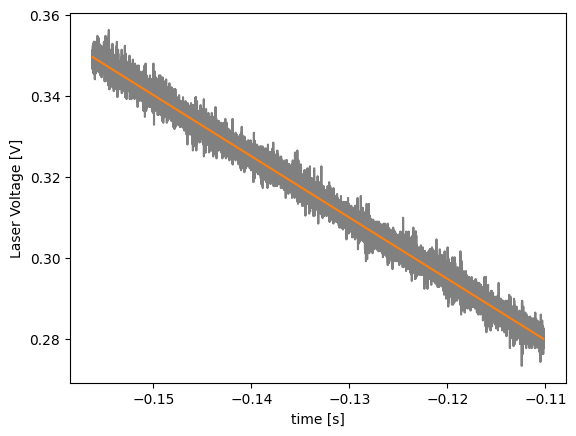

In [40]:
dataframe = read_csv("UMF_2.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
top_trim = 70000
bottom_trim = 20000
t, c1, c2 = data[bottom_trim:top_trim, 0], data[bottom_trim:top_trim, 1], data[bottom_trim:top_trim, 2]

# linear regression for voltage curve)
m, c, _, _, _ = linregress(t, c1)
c1_linearised = m * t + c

plt.plot(t, c1, color='gray')
plt.plot(t, c1_linearised, color='C1')

plt.xlabel("time [s]")
plt.ylabel("Laser Voltage [V]")


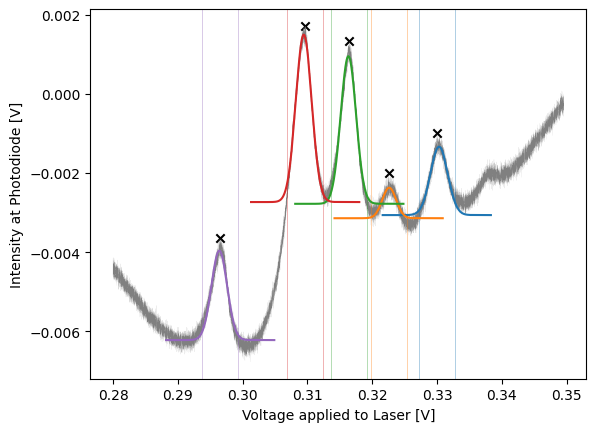

In [41]:
# Find peaks (without gaussians)
peaks = find_peaks(c2, height=-0.004, distance=1000, width=300)[0]
xpeaks = np.array([c1_linearised[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

# voltage at peaks (not good cause of voltage jitter, should fit a straight line first)
peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak
peak_width = 2000 # given in number of neighbouring datapoints
peak_width_shift = 1000 # > 1 shifts boundaries further left
gaussian_fit_boundaries = [(int(i - peak_width_shift - peak_width / 2), int(i + peak_width_shift + peak_width / 2)) for i in peaks]

# fit function
def gaussian(vL, A, v0, vD, DC_offset):
	return A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2)) + DC_offset

peak_info =[]
# fitting and plotting

for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.03, xpeaks[i], 0.01 / 2, -0.001
    (A, v0, vD, DC_offset), _ = curve_fit(gaussian, c1_linearised[LB:UB], c2[LB:UB], initialguess)

    plot_boundary_extension = 4000
    x_gaussian_fit = np.linspace(c1_linearised[LB-plot_boundary_extension], c1_linearised[UB+plot_boundary_extension], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD, DC_offset)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '-', c='C'+str(i), zorder=100)

    # add peak frequency and FWHM to peak_info list
    peak_info.append((v0, vD))

#plot original signal
plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(c1_linearised[::1], c2[::1], linewidth=0.05, c='gray')
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Voltage applied to Laser [V]")
# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=c1_linearised[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)


# UMF peak 3

Text(0, 0.5, 'Laser Voltage [V]')

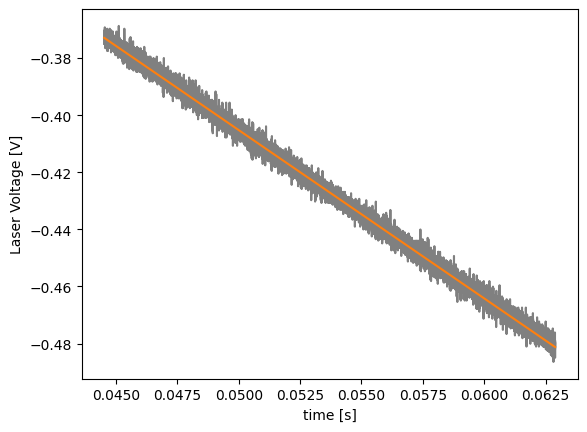

In [42]:
dataframe = read_csv("UMF_3.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
top_trim = 80000
bottom_trim = 40000
t, c1, c2 = data[bottom_trim:top_trim, 0], data[bottom_trim:top_trim, 1], data[bottom_trim:top_trim, 2]

# linear regression for voltage curve
m, c, _, _, _ = linregress(t, c1)
c1_linearised = m * t + c

plt.plot(t, c1, color='gray')
plt.plot(t, c1_linearised, color='C1')

plt.xlabel("time [s]")
plt.ylabel("Laser Voltage [V]")


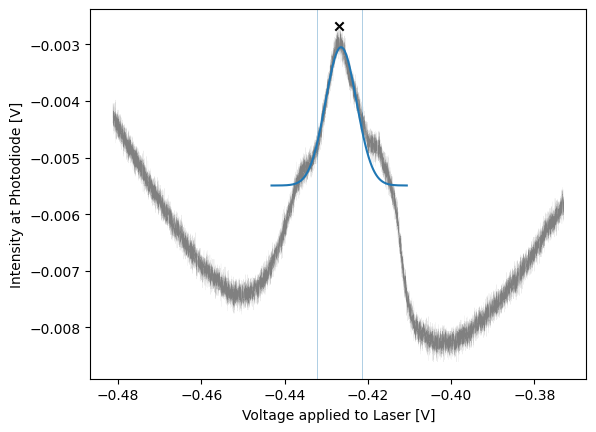

In [43]:
# Find peaks (without gaussians)
peaks = find_peaks(c2, height=-0.004, distance=1000, width=300)[0]
xpeaks = np.array([c1_linearised[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

# voltage at peaks (not good cause of voltage jitter, should fit a straight line first)
peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak
peak_width = 2000 # given in number of neighbouring datapoints
peak_width_shift = 1000 # > 1 shifts boundaries further left
gaussian_fit_boundaries = [(int(i - peak_width_shift - peak_width / 2), int(i + peak_width_shift + peak_width / 2)) for i in peaks]

# fit function
def gaussian(vL, A, v0, vD, DC_offset):
	return A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2)) + DC_offset

peak_info =[]
# fitting and plotting
for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.03, xpeaks[i], 0.01 / 2, -0.001
    (A, v0, vD, DC_offset), _ = curve_fit(gaussian, c1_linearised[LB:UB], c2[LB:UB], initialguess)

    plot_boundary_extension = 4000
    x_gaussian_fit = np.linspace(c1_linearised[LB-plot_boundary_extension], c1_linearised[UB+plot_boundary_extension], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD, DC_offset)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '-', c='C'+str(i), zorder=100)

    # add peak frequency and FWHM to peak_info list
    peak_info.append((v0, vD))

#plot original signal
plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(c1_linearised[::1], c2[::1], linewidth=0.05, c='gray')
plt.ylabel("Intensity at Photodiode [V]")
plt.xlabel("Voltage applied to Laser [V]")
# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=c1_linearised[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)
